# Shapiro Diagram with normalized parameters
### Cythonized, RF current in linear scale

## CPR of $I(\phi)=[\sin(\phi)+\eta\sin(2\phi)]+A(\sin(\phi+C)+\eta\sin[2(\phi+C)])$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import *
from scipy.io import savemat
from scipy.integrate import odeint
%matplotlib inline

In [2]:
%load_ext Cython

### Resistively Shunted Model:

$\frac{d\phi}{dt}=\frac{2eR_N}{\hbar}[I_{DC}+I_{RF}\sin(2\pi f_{RF}t)-I_C\sin\phi]$

Solving $\phi(t)$, then you can get the voltage difference between the superconducting leads:

$V=\frac{\hbar}{2e}\langle\frac{d\phi}{dt}\rangle$

After Normalizing:
$I_{DC}\leftrightarrow \tilde{I_{DC}}=I_{DC}/I_C$,

$I_{RF} \leftrightarrow \tilde{I_{RF}}=I_{RF}/I_C$,

$ V \leftrightarrow \tilde{V}=\frac{V}{I_CR_N}$,

$ R=\frac{dV}{dI} \leftrightarrow \tilde{R}=\frac{R}{R_N}$,


$\because f_0=2eI_CR_N/h$,

$f_{RF} \leftrightarrow \tilde{f_{RF}}=f_{RF}/f_0$,

$t \leftrightarrow \tilde{t}=f_0t$,

The Josephson voltage quantized at $\frac{V}{hf_{RF}f_0/2e}=n \leftrightarrow \frac{V}{f_{RF}f_0}=n$ 

Here, we can set $f_0=1$ or $\frac{I_CR_N}{hf_0/2e}=1$, without loss of generality

The RSJ model simply becomes (omitting $\tilde{}$):

$\frac{d\phi}{dt}=[I_{DC}+I_{RF}\sin(2\pi f_{RF}t)-\sin\phi]$

At equilibrium, $V=\frac{\hbar}{2e}\langle\frac{d\phi}{dt}\rangle \leftrightarrow \tilde{V}=\frac{1}{2\pi}\langle\frac{d\phi}{d\tilde{t}}\rangle$  would also quantized at integers in the Shapiro step regime.



### Cython codes here is to speed up the simulation because python is slower than C:

In [8]:
%%cython --pgo
#To use GNU compiler gcc-10 specified in .bash_profile

cimport numpy as np
from libc.math cimport sin, pi

### cdef is faster but can only be used for cython in this cell
#cpdef can be used for python outside this cell

cdef double CPR(double G, double A, double eta, double C):
    '''
        Current-phase relationship for the junction
    '''
    return sin(G)+eta*sin(2*G)+A*sin(G+C*pi)+A*eta*sin(2*G+2*C*pi)

cpdef double dGdt(G,double t,double i_dc,double i_ac,double f_rf,double A, double eta, double C):
    '''
        RSJ model
    '''
    der =  i_dc + i_ac * sin(2*pi*f_rf*t) - CPR(A,G,eta,C)
    return der 

In [43]:
A=0.2
eta=0.2
C=0.8 # as a unit of pi
f_rf=1

In [40]:
IDC_step=0.1
IDC_array=np.linspace(-10,10,101)
IRF_step=0.1
IRF_array=np.linspace(0,20,101)

print("DC array size: "+str(len(IDC_array)))
print("RF array size: "+str(len(IRF_array)))



DC array size: 101
RF array size: 101


### Plot CPR

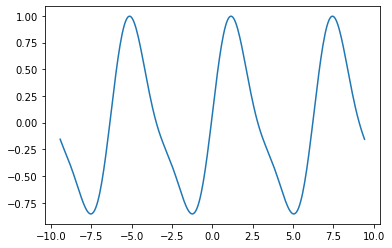

In [44]:
G=np.linspace(-3,3,301)*np.pi
def CPR(G, A, eta, C):
    return np.sin(G)+eta*np.sin(2*G)+A*np.sin(G+C*np.pi)+A*eta*np.sin(2*G+2*C*np.pi)
plt.figure()
plt.plot(G,CPR(G,A,eta,C))


### Test on a single RF current

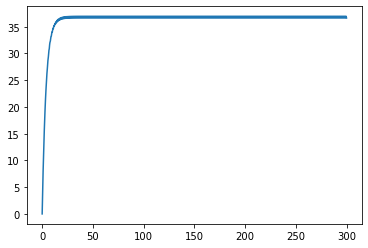

In [53]:
t=np.arange(0,300.01,0.01)/f_rf
V=np.empty([len(IDC_array)])
G_array=np.empty(len(t))
for i in range(0,len(IDC_array)):
    G_array= odeint(dGdt,0,t,args=(IDC_array[i],1,f_rf,A,eta,C))
    V[i]=np.mean(np.gradient(G_array[-1500:,0]))/(0.01/f_rf)/(2*np.pi)
DVDI=2*np.pi*np.gradient(V,IDC_step) #differential resistance dV/dI
plt.plot(t,G_array)
JV=f_rf

In [52]:
print(len(G_array[-1500:,0]))

1500


(0.0, 3.0)

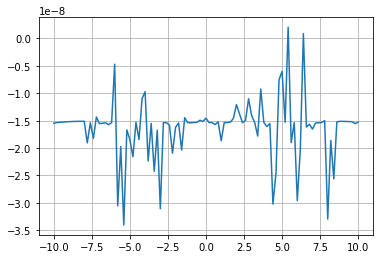

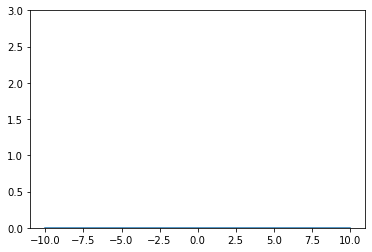

In [54]:
plt.figure()
plt.plot(IDC_array,V/JV)
plt.grid()
plt.figure()
plt.plot(IDC_array,DVDI)
plt.ylim([0,3])

In [ ]:
_name_file = "f_"+str(f_rf)+"_A"+str(np.round(A,3))+"_eta"+str(np.round(eta,3))+"_C"+str(np.round(C,2))+"pi_norm"
_name_title = "f= "+str(f_rf)+"*f0), A= "+str(np.round(A,3))+", eta= "+str(np.round(eta,3))+",C= "+str(np.round(C,2))+"pi_norm"
print(_name_title)
T1=datetime.now()
print (T1)
V=np.empty([len(IRF_array),len(IDC_array)])
for i in range(0,len(IRF_array)):
    print("RF power now: "+str(i)+" of "+str(len(IRF_array))+" ,"+str(datetime.now()),end="\r")
    for j in range(0,len(IDC_array)):
        t=np.arange(0,300.01,0.01)/f_rf
        G_array= odeint(dGdt,0,t,args=(IDC_array[j],IRF_array[i],f_rf,A,C))
        V[i,j]=np.mean(np.gradient(G_array[:-1501,0]))/(0.01/f_rf)/(2*np.pi)

DVDI=2*np.pi*np.gradient(V,IDC_step,axis=1)


print ("It takes " + str(datetime.now()-T1))                
        
plt.figure()
plt.pcolormesh(IDC_array, IRF_array, DVDI, cmap = 'inferno', vmin = 0,linewidth=0,rasterized=True,shading="auto")
plt.xlabel("DC Current($I/I_C$)")
plt.ylabel("RF Current ($I_RF/I_C$)")
plt.colorbar(label = "DV/DI")
plt.title(_name_title)
plt.savefig("DVDI_"+_name_file+".pdf")
plt.show()
                
plt.figure()
plt.pcolormesh(IDC_array, IRF_array, V/f_rf , cmap = 'coolwarm',linewidth=0,rasterized=True,shading="auto")
plt.xlabel("DC Current($I/I_C$)")
plt.ylabel("RF Current ($I_RF/I_C$)")
plt.colorbar(label = "$V/I_CR_N$")
plt.title(_name_title)
plt.savefig("V_"+_name_file+".pdf")
plt.show()

plt.figure()
plt.plot(IDC_array,V[1,:]/f_rf)#/(np.pi*hbar*f/Qe))
plt.show()
plt.figure()
plt.plot(IDC_array,DVDI[1,:])
plt.show()
savemat("data"+_name_file+'.mat',mdict={'IDC':IDC_array,'IRF':IRF_array,'A':A, 'eta':eta, 'f_rf':f_rf,'C':C,'V':V,'DVDI':DVDI})
print('file saved')

f= 1.1*f0), A= 0.909_C= 0.16pi_normalized
2020-09-24 17:40:49.578067
